Initial look through the ```germany_data.csv``` from the European Regional Tracker datasets

## Setup

In [10]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
# mlp font size
import matplotlib
matplotlib.rc('font', size=18)

In [2]:
"""
--------------------------------------------------------------------
    Constants
--------------------------------------------------------------------
"""
data_fname = 'germany_data.csv'

## Column Names

In [3]:
"""
--------------------------------------------------------------------
    Column names in the data file
--------------------------------------------------------------------
"""
# Load the column names
with open(data_fname, 'r') as datafile:
    col_names = datafile.readline().split(';')
    col_names = [c.strip() for c in col_names]

# Print the column numbers along with column number
for entry in enumerate(col_names):
    print('Column %d: %s' % entry)
    
# Invert column names so their indices are easier to lookup
cols_by_name = dict([(c_name,i) for i,c_name in enumerate(col_names)])

Column 0: nuts3_id
Column 1: date
Column 2: region
Column 3: cases
Column 4: deaths
Column 5: population
Column 6: cases_daily
Column 7: deaths_daily


## Number of Entries by Region

In [4]:
"""
--------------------------------------------------------------------
    NUTS3 IDS - How much data is associated with each
--------------------------------------------------------------------
"""
# List of columns to extract
selected_columns = [
    'cases',
    'deaths',
    'cases_daily',
    'deaths_daily'
]

# Table to store the results of the parsing
nuts3_id_table = defaultdict(lambda: defaultdict(int))

# Convert selected columns into column numbers
selected_column_inds = [
    cols_by_name[c_name] for c_name in selected_columns
]

with open(data_fname, 'r') as datafile:
    # Skip the first line
    datafile.readline()
    
    # Read through the data in the file and 
    for line in datafile:

        # Split on the ; deliminter
        split_line = line.split(';')
        
        # Save the NUTS3 ID
        nuts3_id = split_line[0]

        # Loop over selected columns
        for i, n_i in enumerate(selected_column_inds):
            # Get the value of the i-th selected column
            # for this line
            c_val = split_line[n_i] 
            # If the value is not missing, then increment
            # the counters for this column and this region
            if len(c_val) > 0:
                nuts3_id_table[nuts3_id][selected_columns[i]] += 1
            
        # Check to see if the population of the region
        # has changed
        # TODO: implemement

In [5]:
# Print out number of regions
all_nuts3_ids = sorted(list(nuts3_id_table.keys()))
num_regions = len(all_nuts3_ids)
print('Number of regions:', num_regions)

Number of regions: 401


In [6]:
# Reverse the nuts3_id_table to map from selected column 
# to a list of whose i-th entry if the number of datapoints
# for the i-th region (order defined by all_nuts3_ids)
num_datapoints_by_column = dict([
    (c_name, np.zeros(num_regions)) for c_name in selected_columns
])
for i, nuts3_id in enumerate(all_nuts3_ids):
    for c_name in selected_columns:
        num_datapoints_by_column[c_name][i] = nuts3_id_table[nuts3_id][c_name]

In [7]:
# Check to see if all regions have the same number of entries for
# each column
for c_name in selected_columns:
    n_entries_for_first_region = num_datapoints_by_column[c_name][0]
    if np.all(num_datapoints_by_column[c_name] == n_entries_for_first_region):
        print('All regions have the same number of entries for', c_name)
    else:
        print('Not all region have the same number of entries for', c_name)

All regions have the same number of entries for cases
All regions have the same number of entries for deaths
All regions have the same number of entries for cases_daily
All regions have the same number of entries for deaths_daily


## Population by Regions

Checking to see if the population for each region is constant over time

In [8]:
# Dictionary mapping from nuts3 id to list of the 
# regions population over time
population_by_region = defaultdict(list)

with open(data_fname, 'r') as datafile:
    # Skip the first line
    datafile.readline()
    
    # Read through the data in the file and 
    for line in datafile:

        # Split on the ; deliminter
        split_line = line.split(';')
        
        # Get the NUTS3 ID and population
        nuts3_id = split_line[0]
        population = split_line[5]

        # Make an entry in the ```population_by_region ``` dict
        population_by_region[nuts3_id].append(population)

In [9]:
constant_population = []

# Check to see if population is constant for all the regions
for i, nuts3_id in enumerate(all_nuts3_ids):
    init_pop = population_by_region[nuts3_id][0]
    for p in population_by_region[nuts3_id]:
        if p != init_pop:
            constant_population.append(False)
            break
    if len(constant_population) != i:
        constant_population.append(True)
        
# Print out constant_population to see if all regions
if all(constant_population):
    print('All regions have a constant population value')
else:
    print('Some regions dont have a constant population value' )

All regions have a constant population value


## Reformatting the data for PyTorch

Going to break the data apart into five files

**File 1**: ```region_data.csv``` : (# of regions,2)-NumPy array recording data about each region. In particular, for each region I'll record the NUTS3 ID and population

**File 2**: ```cases.pt``` : (# of regions, # of data points) PyTorch array tracking the number of total cases by region as a function of time.

**Files 3-5** Same as File 2, but for total deaths, cases by day, and deaths by day.

In [11]:
"""
File 1: Region Data
"""
# Build the numpy array storing the region data
region_data = []
for i, nut3_id in enumerate(all_nuts3_ids):
    region_data.append([nut3_id, int(population_by_region[nut3_id][0])])
region_data = np.array(region_data, dtype='object')

# Write the data to file
np.savetxt(
    './data/region_data.csv', region_data, 
    delimiter=',', fmt=('%s', '%d')
)

In [31]:
"""
File 2-5: Actual Time-series
"""

# Part 1: Setup Torch tensors to store the time series data
U = {}
T_max = 0
# Loop over columns containing data
for c_name in num_datapoints_by_column:
    
    # Save the sequence length (# data points) for this data type
    T = int(num_datapoints_by_column[c_name][0])
    T_max = max(T_max, T)
    
    # Create a pytorch array to store the time-series for 
    # this data type
    u = torch.zeros((num_regions, T)).int()
    
    # Add to the dictionary of torch tensors
    U[c_name] = u

    
# Part 2: Go through the data file again and extract the time-series
# Variable to keep track of which timestep we're on for the region 
#    we're currently process
t = 0
with open(data_fname, 'r') as datafile:
    
    # Skip the first line
    datafile.readline()
    
    # Loop over the regions
    for i in range(num_regions):

        # Parse all lines associated with this region
        for t in range(T_max):
            line = datafile.readline()

            # Split on the ; deliminter
            split_line = line.split(';')

            # Save the cases, deaths
            U['cases'][i,t] = int(split_line[3])
            U['deaths'][i,t] = int(split_line[4])
            
            # Save cases_daily and deaths_daily if they are present
            # (i.e. for t > 0)
            if t > 0:
                U['cases_daily'][i,t-1] = int(split_line[6])
                U['deaths_daily'][i,t-1] = int(split_line[7])
                
# Save the data to file now
for c_name in U:
    torch.save(U[c_name], './data/%s.pt' % c_name)

## Functions for reading the data from file

TODO:
- Add functionality to normalize sequences to mean 0, stdev 1
- Add functionality to normalize sequences by region population / 10000
- Add functionality to compute the mean over the entire data

In [63]:
def load_germany_data(dtype='cases_daily', seq_len=None, country_wide_avg=False,
        per_10k_population=True, normalize=True
    ):
    """
    PARAMETERS
    
        dtype        : String. Controls which column the returned data comes from
                       Options: 'cases', 'deaths', 'cases_daily', 'deaths_daily'
                       Default: 'causes_daily'
    
        seq_len      : Int. Length of the sequences to return. 
                       If 'None', returns the maximum sequence length
                       Default: None
        
        country_wide_avg   : Boolean. Set to true to collapse the data into a single
                       time series representing the average over the entire country
                       Default: False
                       
        per_10k_population : 
        
        
        normalize    : Boolean. Set to true to normalize the returned data to have 
                       zero mean and unit variance
    
    RETURNS
    
        u            : (# regions, seq len)-PyTorch tensor storing the time-series data
                       for Germany. Here, # regions = 1 if country_wide_avg=True, otherwise 401

    """
    # Verify the data type if valid
    if dtype not in ['cases', 'deaths', 'cases_daily', 'deaths_daily']:
        raise ValueError('dtype %s not recognized' % dtype)
    
    # Load the raw Torch data from file
    u = torch.load('./data/%s.pt' % dtype).float()
    
    # Set the sequence length
    if seq_len and seq_len < u.shape[1]:
        u = u[:,seq_len]
    
    # Compute the average over all regions
    if country_wide_avg:
        u = u.mean(axis=0)
    
    # Normalize by population
    elif per_10k_population:
        # Load the population data from file
        population_data = np.loadtxt(
            './data/region_data.csv', dtype='object', delimiter=','
        )[:,1].astype('int')
        
        # Normalize 
        u = (u.T * 10000 / population_data).T
          
    # Normalize to zero mean, unit variance
    if normalize:
        u -= torch.mean(u)
        u /= torch.std(u)
    
    # Return the sequence(s)
    return u

In [75]:
u = load_germany_data(dtype='cases_daily', country_wide_avg=True)

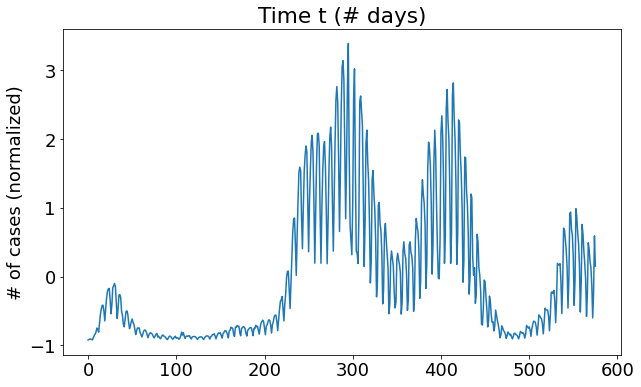

In [79]:
plt.figure(figsize=(10,6))
plt.title('Germany: Normalized Daily Cases, Country-wide avg')
plt.title('Time t (# days)')
plt.ylabel('# of cases (normalized)')
plt.plot(u)
plt.show()